In [3]:
%pip install fastMONAI
from fastMONAI.vision_all import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/Datasets/datasetT2_200.csv')

Mounted at /content/gdrive


In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)
len(train_df), len(test_df)

(120, 80)

In [6]:
train_df

,t2_path,subject_id,age_at_scan,age
2,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00053XX04_ses-8607_desc-restore_T2w.nii.gz,8607,40.43,40
77,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00144XX13_ses-47701_desc-restore_T2w.nii.gz,47701,40.00,40
46,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00107XX08_ses-36300_desc-restore_T2w.nii.gz,36300,41.29,41
187,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00329XX16_ses-105400_desc-restore_T2w.nii.gz,105400,39.43,39
191,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00337XX16_ses-107000_desc-restore_T2w.nii.gz,107000,39.29,39
...,...,...,...,...
106,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00181XX09_ses-60000_desc-restore_T2w.nii.gz,60000,40.86,40
14,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00068XX11_ses-20701_desc-restore_T2w.nii.gz,20701,40.71,40
92,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00161XX05_ses-53100_desc-restore_T2w.nii.gz,53100,36.71,36
179,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00313XX08_ses-100000_desc-restore_T2w.nii.gz,100000,39.14,39


In [7]:
train_df.age.min(), train_df.age.max(), train_df.age.mean()

(32, 45, 39.1)

In [ ]:
import matplotlib.pyplot as plt

(array([ 0.,  0.,  0.,  3.,  2.,  4.,  4.,  8.,  9., 10., 18., 24., 20.,
         9.,  4.,  4.,  1.]),
 array([29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46.]),
 <BarContainer object of 17 artists>)

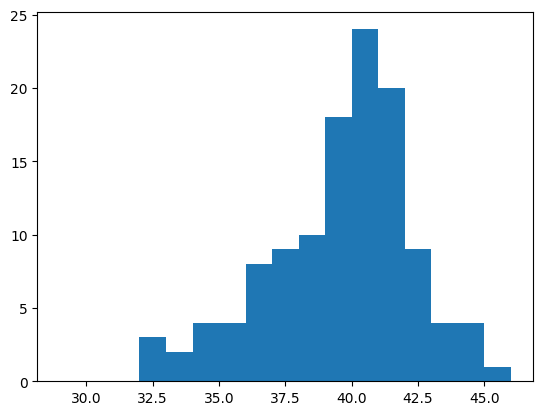

In [8]:
plt.hist(train_df['age'], bins = 17, range = [29,46])

In [9]:
med_dataset = MedDataset(path= '/content/gdrive/MyDrive/Datasets/T2Restore200', max_workers=12)
data_info_df = med_dataset.summary()

In [10]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,217,290,290,0.5,0.5,0.5,RAS+,/content/gdrive/MyDrive/Datasets/T2Restore200/sub-CC00051XX02_ses-7702_desc-restore_T2w.nii.gz,200


In [11]:
resample, reorder = med_dataset.suggestion()

In [12]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[217.0, 290.0, 290.0]

In [13]:

bs=4
item_tfms = [ZNormalization(), PadOrCrop(img_size), RandomAffine(scales=0, degrees=5, isotropic=False)] 
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), RegressionBlock), 
                      splitter=RandomSplitter(seed=32),
                      get_x=ColReader('t2_path'),
                      get_y=ColReader('age'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [14]:
dls = dblock.dataloaders(train_df, bs=bs)

In [15]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(96, 24)

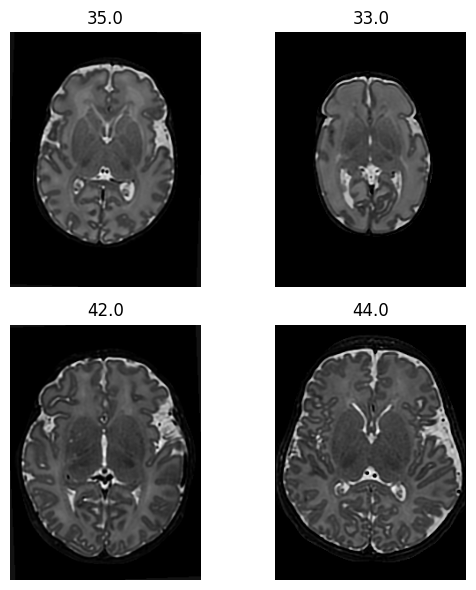

In [16]:
dls.show_batch(anatomical_plane=2)

In [17]:
from monai.networks.nets import Regressor

model = Regressor(in_shape=[1,217, 290, 290], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

In [18]:
loss_func = L1LossFlat()
learn = Learner(dls, model, loss_func=loss_func, metrics=[mae])
learn.summary()

Regressor (Input shape: 4 x 1 x 217 x 290 x 290)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 109 x 145  
Conv3d                                    448        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    448        True      
____________________________________________________________________________
                     4 x 32 x 55 x 73 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    27680      True      
InstanceNorm3d        

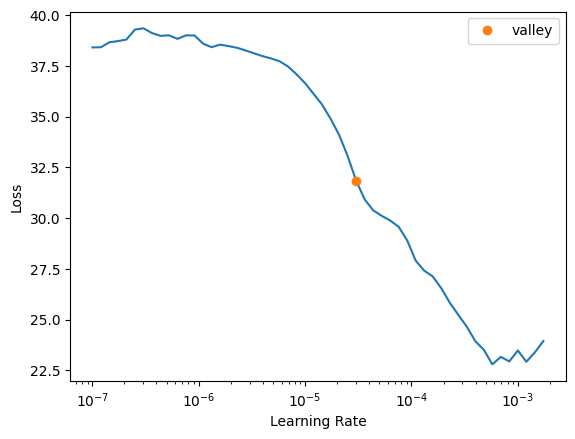

In [19]:
lr = learn.lr_find()

In [20]:
print(lr.valley)

3.0199516913853586e-05


In [21]:
learn.fit_one_cycle(100, lr.valley, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=1))

epoch,train_loss,valid_loss,mae,time
0,36.162750,32.953297,32.953297,27:40
1,31.947872,25.026731,25.026731,27:29
2,25.552935,11.897556,11.897556,27:06
3,16.451296,6.877790,6.877790,27:10
4,10.890728,2.502094,2.502094,26:47
5,7.381626,1.596901,1.596901,26:53
6,5.176319,1.556433,1.556433,30:25
7,3.718126,1.534599,1.534599,26:43
8,2.855424,1.276000,1.276000,26:23
9,2.111009,1.559630,1.559630,26:38


No improvement since epoch 8: early stopping


In [22]:
learn.save('model-brainage');
learn.load('model-brainage'); 


In [23]:
interp = Interpretation.from_learner(learn)

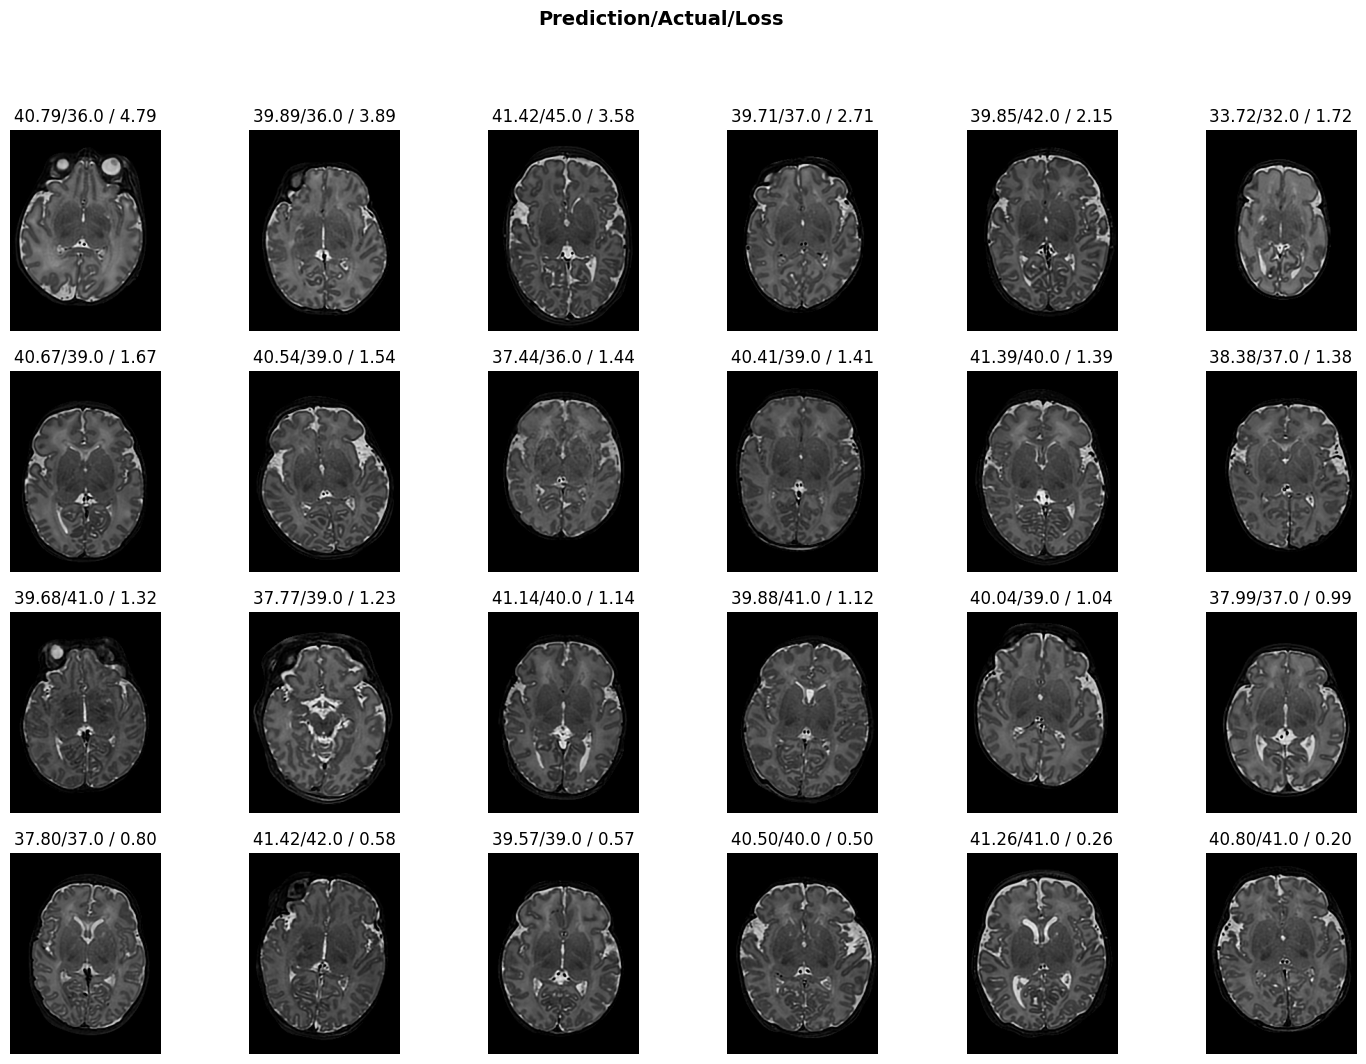

In [24]:
interp.plot_top_losses(k=24, anatomical_plane=2)

In [25]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

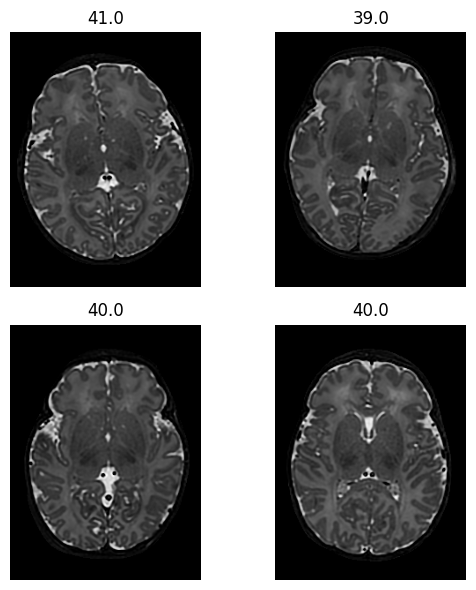

In [26]:
test_dl.show_batch(anatomical_plane=2)

In [27]:
pred_acts, labels = learn.get_preds(dl=test_dl)

In [28]:
len(pred_acts)

80

In [29]:
pred_acts.shape, labels.shape

(torch.Size([80, 1]), torch.Size([80]))

In [30]:
mae(pred_acts, labels)

TensorBase(1.3596)

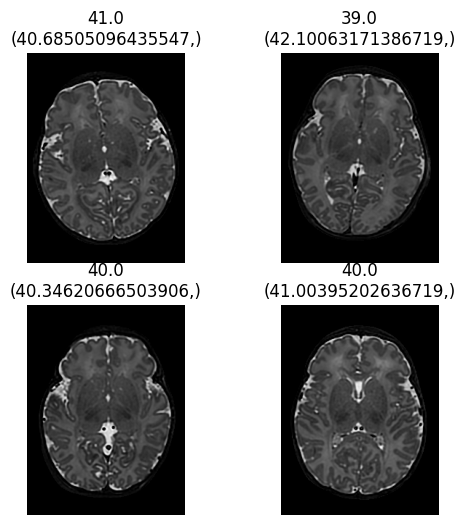

In [31]:
learn.show_results(anatomical_plane=2, dl=test_dl)